# Replicando análisis de mortalidad de COVID para Chile
El siguiente notebook tiene como objetivo replicar el análisis realizado por The Economist para la realidad de Chile

Este análisis está inspirado en la publicación realizada por The Economist que pueden encontrar en **[AQUÍ](https://www.economist.com/graphic-detail/2020/04/03/covid-19s-death-toll-appears-higher-than-official-figures-suggest)**
<img src="../img/img.png">


## Datos históricos de mortalidad
La búsqueda de datos sobre mortalidad resultó ser una difícil tarea, de hecho la data histórica desagregada a nivel granular de defunción anonimizada solo llega hasta 2017. Esto porque la data de defunciones que debe ser publicada por el Instituto Nacional de Estadísticas (INE) y por el Departamento de Estadísticas de Información de Salud (DEIS), tarda años en ser procesada y publicada.

Para este análisis los datos fueron obtenidos desde la página **[DEIS](https://deis.minsal.cl/#datosabiertos)**, específicamente de la sección datos abiertos, el dataset se llama **["DEF_1990-2017"](https://repositoriodeis.minsal.cl/DatosAbiertos/Vitales/DEF_1990-2017.rar)**

A continuación se puede apreciar una muestra de los datos que contiene este dataset:

In [309]:
# Descarga del archivo usando urllib

# importamos las librerias necesarias
import urllib.request
import os 

if not (os.path.exists("DEF_1990-2017.rar")):
    url = 'https://repositoriodeis.minsal.cl/DatosAbiertos/Vitales/DEF_1990-2017.rar'
    RARmort = urllib.request.urlretrieve(url, 'DEF_1990-2017.rar') # El archivo quedará almacenado en la misma carpeta que el notebook

In [310]:
import sys
# Estas librerías probablemente no las tendrán instaladas por lo que les recomiendo 
# realizar una vez su ejecución quitando el comentario
#!conda install --yes --prefix {sys.prefix} -c conda-forge patool

#----------------------------------------------------
# Descompresión del archivo y lectura en un dataframe
#----------------------------------------------------

# importamos las librerias necesarias
import pandas as pd
import patoolib
import pandas as pd

# La descompresion queda en el actual directorio
cwd = os.path.abspath(os.getcwd())
patoolib.extract_archive("DEF_1990-2017.rar", outdir=cwd, verbosity=-1)

# lectura del archivo csv con encoding cp1252, es importante el enconding sino la lectura falla
defHist = pd.read_csv('DEF_1990-2017.csv', sep = ";" , encoding='cp1252', low_memory=False)

#Eliminamos los archivos que ya no usamos.
os.remove('DEF_1990-2017.rar')
os.remove('DEF_1990-2017.csv')
os.remove('Ficha Dato Abierto Defunciones.xlsx')

#Establecemos un display ridículamente alto para que podamos ver todas las columnas del dataset
pd.set_option("display.max_columns", 500)

#Luego revisamos visualmente las variables del dataset
defHist.head()

,ID_FALLECIDO,DIA_DEF,MES_DEF,ANO_DEF,FECHA_DEF,SEXO,GLOSA_SEXO,DIA_NAC,MES_NAC,ANO_NAC,FECHA_NACIMIENTO,EDAD_CANT,EDAD_TIPO,GLOSA_EDAD_TIPO,EST_CIVIL,GLOSA_EST_CIVIL,CURSO_INS,NIVEL_INS,GLOSA_NIVEL_INS,ACTIVIDAD,GLOSA_ACTIVIDAD,OCUPACION,GLOSA_OCUPACION,CATEGORIA,GLOSA_CATEGORIA,ANO_INSCR,LOCAL_DEF,GLOSA_LOCAL_DEF,REG_RES,GLOSA_REG_RES,SERV_RES,GLOSA_SERV_RES,COMUNA,GLOSA_COMUNA_RESIDENCIA,URBANO_RURAL,DIAG1,GLOSA_SUBCATEGORIA_DIAG1,CODIGO_CATEGORIA_DIAG1,GLOSA_CATEGORIA_DIAG1,CODIGO_GRUPO_DIAG1,GLOSA_GRUPO_DIAG1,CAPITULO_DIAG1,GLOSA_CAPITULO_DIAG1,DIAG2,GLOSA_SUBCATEGORIA_DIAG2,CODIGO_CATEGORIA_DIAG2,GLOSA_CATEGORIA_DIAG2,CODIGO_GRUPO_DIAG2,GLOSA_GRUPO_DIAG2,CAPITULO_DIAG2,GLOSA_CAPITULO_DIAG2,AT_MEDICA,GLOSA_AT_MEDICA,CAL_MEDICO,GLOSA_CAL_MEDICO,CER_MES,CER_ANO,FUND_CAUSA,GLOSA_FUND_CAUSA,COD_MENOR,GLOSA_COD_MENOR,PESO,GESTACION,NUTRITIVO,GLOSA_NUTRITIVO,EDAD_MADRE,EST_CIV_MADRE,GLOSA_EST_CIV_MADRE,ACTIV_MADRE,GLOSA_ACTIV_MADRE,OCUPA_MADRE,GLOSA_OCUPA_MADRE,CATEG_MADRE,GLOSA_CATEG_MADRE,CURSO_MADRE,NIVEL_MADRE,GLOSA_NIVEL_MADRE,HIJ_VIVOS,HIJ_FALLECIDOS,HIJ_MORTINATOS,HIJ_TOTAL,PARTO_ABORTO,GLOSA_PARTO_ABORTO,DIA_PARTO,MES_PARTO,ANO_PARTO,FECHA_PARTO,EDAD_PADRE,ACTIV_PADRE,GLOSA_ACTIV_PADRE,OCUPA_PADRE,GLOSA_OCUPA_PADRE,CATEG_PADRE,GLOSA_CATEG_PADRE,CURSO_PADRE,NIVEL_PADRE,GLOSA_NIVEL_PADRE
0,DD1E27F3C672A48FC03201517F359219D583F557,16.0,6.0,1998,1998-06-16,1.0,Hombre,29.0,12.0,1906.0,1906-12-29,92,1.0,Edad en años,2.0,Casado,5.0,1.0,Superior,0.0,Inactivo,5,Jubilado,0.0,Inactivo,NaN,2.0,Casa Habitación,13,Metropolitana de Santiago,12,Metropolitano Oriente,13120,Ñuñoa,1.0,R54X,SENILIDAD,R54,Senilidad,R50-R69,Síntomas y signos generales,R00-R99,"Síntomas, signos y hallazgos anormales clínico...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Si,3.0,Otro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C3D055440B5B37EFD89C04C7975F6A081CE43781,3.0,7.0,2007,2007-07-03,1.0,Hombre,14.0,1.0,1915.0,1915-01-14,92,1.0,Edad en años,3.0,Viudo,6.0,3.0,Secundaria,0.0,Inactivo,5,Jubilado,0.0,Inactivo,NaN,2.0,Casa Habitación,13,Metropolitana de Santiago,12,Metropolitano Oriente,13123,Providencia,1.0,I251,ENFERMEDAD ATEROSCLEROTICA DEL CORAZÓN,I25,Enfermedad isquémica crónica del corazón,I20-I25,Enfermedades isquémicas del corazón,I00-I99,Enfermedades del sistema circulatorio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Si,1.0,Médico tratante,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,578A350EE1B1A24CADAC566A79F16130B27E3B25,6.0,9.0,2006,2006-09-06,1.0,Hombre,25.0,7.0,1911.0,1911-07-25,95,1.0,Edad en años,2.0,Casado,6.0,4.0,Básico o Primario,0.0,Inactivo,5,Jubilado,0.0,Inactivo,NaN,3.0,Otro,13,Metropolitana de Santiago,11,Metropolitano Central,13119,Maipú,1.0,J189,"NEUMONIA, NO ESPECIFICADA",J18,"Neumonía, organismo no especificado",J09-J18,Influenza [gripe] y neumonía,J00-J99,Enfermedades del sistema respiratorio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Si,1.0,Médico tratante,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B70FD857D03AC268148A7190E2824A2C4DEE42DA,13.0,6.0,1998,1998-06-13,1.0,Hombre,18.0,3.0,1915.0,1915-03-18,83,1.0,Edad en años,3.0,Viudo,4.0,4.0,Básico o Primario,0.0,Inactivo,5,Jubilado,0.0,Inactivo,NaN,2.0,Casa Habitación,13,Metropolitana de Santiago,12,Metropolitano Oriente,13113,La Reina,1.0,C349,"TUMOR MALIGNO DE LOS BRONQUIOS O DEL PULMÓN, P...",C34,Tumor maligno de los bronquios y del pulmón,C30-C39,Tumores malignos de los órganos respiratorios ...,C00-D48,Tumores [Neoplasias],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Si,1.0,Médico tratante,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Datos de Población
Los datos de población corresponden a una proyección de realizada por el INE en el informe "CHILE Proyecciones y Estimaciones de Poblacion Total del Pais 1950-2050", el cual se puede encontrar **[AQUÍ](http://estadistica.ssmso.cl/downloads/proyecciones/CHILE-Proyecciones-y-Estimaciones-de-Poblacion-Total-del-Pais-1950-2050.pdf)**

A continuación se puede ver una muestra de esos datos:

In [247]:
# Con este dataset, vamos a incluir manual los datos de población, proyectada por el INE, estos están en pdf en 
# http://estadistica.ssmso.cl/downloads/proyecciones/CHILE-Proyecciones-y-Estimaciones-de-Poblacion-Total-del-Pais-1950-2050.pdf
# se puede automatizar con tabula-py pero ante tan pocos datos y que no cambiarán, prefiero hacerlo manual.
import numpy as np
import math

proyPobla = pd.DataFrame(np.array([[1990, 13178782], [1991, 13422010], [1992, 13665241], [1993, 13908473], [1994, 14151708]\
                                   , [1995, 14394940], [1996, 14595504], [1997, 14796076], [1998, 14996647], [1999, 15197213]\
                                   , [2000, 15397784], [2001, 15571679], [2002, 15745583], [2003, 15919479],[2004, 16093378]\
                                   , [2005, 16267278], [2006, 16432674], [2007, 16598074], [2008, 16763470], [2009, 16928873]\
                                   , [2010, 17094270], [2011, 17248450], [2012, 17402630], [2013, 17556815], [2014, 17711004]\
                                   , [2015, 17865185], [2016, 18001964], [2017, 18138749], [2018,18275530],[2019,18412316],[2020,18549095]]),
                   columns=['ANIO', 'POBLACION'])



## Tratamiento de datos históricos y cálculo de defunciones por cada 100.000 habitantes

Ya con la información de población, es posible estimar la tasa de mortalidad por cada 100.000 habitantes, y dado que tenemos datos desde 1990 generé una serie semanal de datos (podría ser diaria pero más delante se justificará porque no fue así), promediando las defunciones semanales de cada año, y calculé un intervalo de confianza para determinar posteriormente si la serie semanal 2020 tiene diferencias significativas. 

Esta sería una muestra del dataframe, donde:
- mean: promedio semanal de tasa de defunción por cada 100.000 habitantes
- hi = limite superior de intervalo de confianza (95%)
- low = limite inferior de intervalo de confianza (95%)

In [313]:
# Lo primero es reducir el dataset a los campos que nos puedan ser útiles ya que son 100
defuncionesHist = defHist[['ID_FALLECIDO','ANO_DEF', 'MES_DEF', 'DIA_DEF']]

# generamos unmerge por año para unir los dos dataframes
defConsol = defuncionesHist.merge(proyPobla, how = 'left', left_on ='ANO_DEF', right_on = 'ANIO')

# agrupamos la cantidad de defunciones por año, día, mes
agrupDefun = defuncionesHist.groupby(['ANO_DEF', 'MES_DEF', 'DIA_DEF'], as_index = False)['ID_FALLECIDO'].count()
agrupDefun = agrupDefun.rename(columns={"ID_FALLECIDO": "CANT_FALLECIDOS"})

# Unimos las tablas de pobalación y defunciones

defConsol = agrupDefun.merge(proyPobla, how = 'left', left_on ='ANO_DEF', right_on = 'ANIO')

#generamos el campo de "defunciones por cada 100.000 habitantes" y el campo SEMANA
defConsol['DEF_X_10000'] = defConsol['CANT_FALLECIDOS'] / defConsol['POBLACION'] * 100000
defConsol['Fecha'] = defConsol['ANO_DEF'].astype(str) + '-' + defConsol['MES_DEF'].astype(int).astype(str) + '-' +defConsol['DIA_DEF'].astype(int).astype(str)
defConsol['Fecha'] = pd.to_datetime(defConsol['Fecha'])
defConsol['week'] =  defConsol['Fecha'].dt.week

#Finalmente agregamos por promedio de defuncion por 100.000 
fPromFallecidos = defConsol.groupby(['week', 'ANO_DEF'], as_index = False)['DEF_X_10000'].sum()
fPromFallecidos = fPromFallecidos.groupby(['week'], as_index = False)['DEF_X_10000'].agg(['mean', 'count', 'std'])

fPromFallecidos = fPromFallecidos.reset_index()
fPromFallecidos['hi'] = fPromFallecidos['mean'] + (1.96 * fPromFallecidos['std'] / np.sqrt(fPromFallecidos['count']))
fPromFallecidos['low'] = fPromFallecidos['mean'] - (1.96 * fPromFallecidos['std'] / np.sqrt(fPromFallecidos['count']))
fPromFallecidos.head()

,week,mean,count,std,hi,low
0,1,10.069146,28,2.096929,10.845860,9.292433
1,2,9.792310,28,0.472799,9.967437,9.617183
2,3,9.710809,28,0.575868,9.924113,9.497504
3,4,9.616349,28,0.578925,9.830786,9.401912
4,5,9.478948,28,0.469246,9.652759,9.305136


## Serie de defunciones 2020

Lamentablemente aún no existen estadísticas diarias sobre defunciones reales, sin embargo, a partir del 15/05/2020 el Registro Civil liberó el dato de la cantidad diaria de inscripciones de defunción, que como ellos señalan en su [web]('https://estadisticas.sed.srcei.cl/defhst') "Cabe señalar, que la fecha de inscripción, no representa la fecha de defunción de una persona.", pero que podría servir como proxy de las defunciones reales, por ello hice una comparación de las defunciones reales versus las inscritas para establecer si es posible hacer esta aproximación.
Asimismo, quiero hacer hincapié en que la información liberada está incompleta, ya que los certificados tienen **fecha de defunción**, pero esto **NO FUE PUBLICADO**, siendo que este dato genera una mejor estimación de la realidad.

In [314]:
# Partimos haciendo una copia del histórico, y filtrando que sea mayor al año más antiguo del que se publicó data del certificado el cual corresponde a 2010
defuncionesHist2010 =  defuncionesHist.copy()
defHist2010 = defuncionesHist2010[defuncionesHist2010['ANO_DEF'] >= 2010]

In [315]:
# Vamos a dejar el DF en el mismo formato que los archivos descargables del SRCeI, 
# agregando por año, mes, día, la cantidad de fallecidos
def2010 = defHist2010.groupby(by=['ANO_DEF', 'MES_DEF',	'DIA_DEF'])['ID_FALLECIDO'].count().reset_index()

# Creamos el campo id que corresponde a la fecha, y lo pasamos a formato fecha de pandas
def2010['id'] = def2010['ANO_DEF'].astype(str) + '-' + def2010['MES_DEF'].astype(int).astype(str) + '-' +def2010['DIA_DEF'].astype(int).astype(str)
def2010['id'] = pd.to_datetime(def2010['id'])

# Renombramos el campo de conteo
def2010 = def2010.rename(columns = {'ID_FALLECIDO': 'REAL'})

# Esta parte aún no está automatizada con los archivos desde el origen, (tendrán que creerme que son los datos o 
# visitar el sitio https://estadisticas.sed.srcei.cl/defhst y comprobarlo por ustedes mismos), 
# quizás despues haga la automatización con Selenium
# mientras quedarán en la carpeta certificados de este repositorio
# Cargamos los df
dfproxy = pd.DataFrame()

for i in range(2010, 2018):
    url = 'certificados/' + str(i) + '.xlsx'
    dfproxy = dfproxy.append(pd.read_excel(url, encoding = 'cp-1252'))

# Agregamos por año, mes y día la columna total, ya que en el archivo los datos vienen desagregados por comuna.
dfproxyG = dfproxy.groupby(by = ['AÑO', 'MES', 'DIA'])['TOTAL'].sum().reset_index()

# Al igual que con los datos históricos hacemos un id fecha para poder luego hacer el cruce
dfproxyG['id'] = dfproxyG['AÑO'].astype(str) + '-' + dfproxyG['MES'].astype(int).astype(str) + '-' +dfproxyG['DIA'].astype(int).astype(str)
dfproxyG['id'] = pd.to_datetime(dfproxyG['id'])

# renombramos la columna de totalización
dfproxyG = dfproxyG.rename(columns = {'TOTAL': 'PROXY'})

#Lo primero que vamos a revisar es si al totalizar la cantidad de defunciones de ambos dataset, la diferencia es muy alta, pues de ser así no tendría sentido seguir con la aproximación.
txt = 'Según datos históricos, entre 2010 y 2017 hubo ' \
+ def2010['REAL'].agg(['sum'])[0].astype(str) \
+ " fallecidos, mientras que de acuerdo a los Certificados hubo " \
+ dfproxyG['PROXY'].agg(['sum'])[0].astype(str) \
+ ' defunciones inscritas, lo anterior representa un ' \
+ str(round((dfproxyG['PROXY'].agg(['sum'])[0].astype(float) - def2010['REAL'].agg(['sum'])[0].astype(float))/def2010['REAL'].agg(['sum'])[0].astype(float) * 100.0, 2)) \
+ '% de sobreestimación si usamos el certificado sobre las defunciones reales'
print(txt)

Según datos históricos, entre 2010 y 2017 hubo 805447 fallecidos, mientras que de acuerdo a los Certificados hubo 809966 defunciones inscritas, lo anterior representa un 0.56% de sobreestimación si usamos el certificado sobre las defunciones reales


Al menos en términos gruesos, las cifras son similares y el error pareciera no ser significativo.

Ahora vamos a visualizar el comportamiento diario para ver si podemos realizar el análisis con esa temporalidad

In [316]:
dfTemp = def2010.merge(dfproxyG, how = 'left', right_on = 'id', left_on = 'id')

***Gráfico 1: Comparación entre series diarias de defunciones, real versus las inscritas 2010 - 2017***

<function matplotlib.pyplot.show(*args, **kw)>

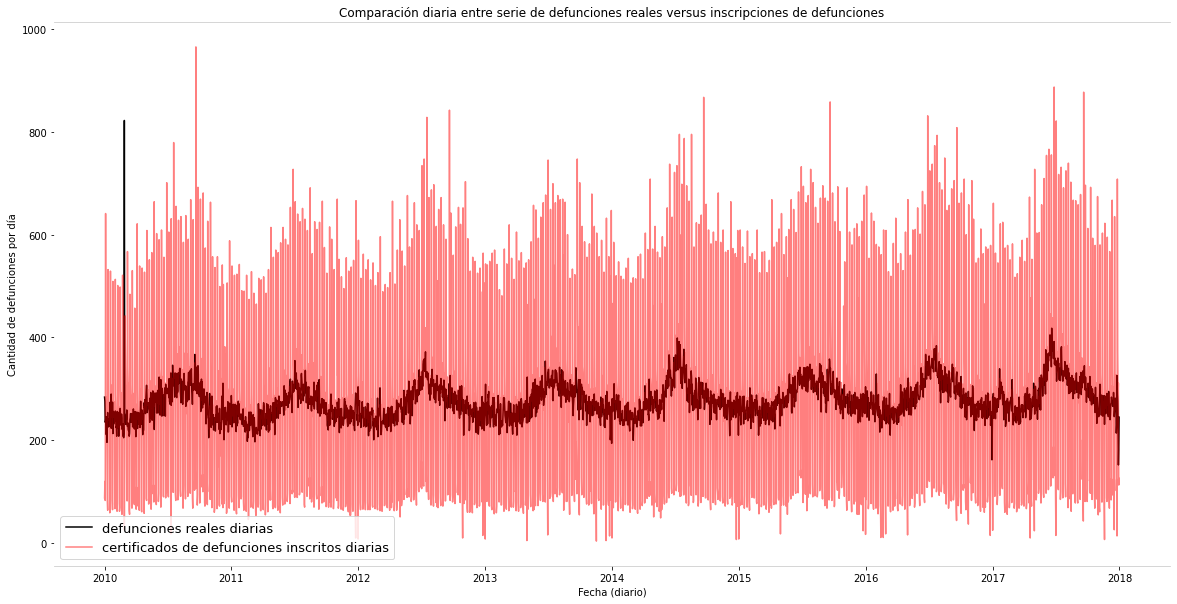

In [319]:
#--------------------------------------------
# GRÁFICO 1
#-------------------------------------------
# Librerías necesarias
import matplotlib.pyplot as plt
import numpy as np

# inciamos el gráfico y sus ejes
fig, ax = plt.subplots()
ax.plot('id', 'REAL', data=dfTemp, color='black')
ax.plot('id', 'PROXY', data=dfTemp, color='red', alpha = 0.5)

# formateamos la grilla
ax.grid(False)

# seteamos leyendas y título
ax.set_xlabel('Fecha (diario)')
ax.set_ylabel('Cantidad de defunciones por día')
ax.set_title('Comparación diaria entre serie de defunciones reales versus inscripciones de defunciones')

# tamaño del grafico
fig.set_figheight(10)
fig.set_figwidth(20)

# color de los ejes 
ax.spines['bottom'].set_color('#cccccc')
ax.spines['top'].set_color('#cccccc') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(('defunciones reales diarias', 'certificados de defunciones inscritos diarios')
          , loc='lower left', shadow=False, fontsize = 13)

plt.show

Se puede apreciar en el gráfico 1 que los comportamientos de las series diarias son bastante disímiles, por lo que no es posible usar la data como proxy a este nivel, pues la aproximación presentaría mucho ruido.
Frente a esta problemática, decidí pasar al siguiente nivel de agregación temporal, **semana**.

In [320]:
# Creamos el campo semana usando la función pandas para ello.
dfTemp['week'] = dfTemp['id'].dt.week

# agrupamos por semana y año
toplot = dfTemp.groupby(by=['week', 'AÑO']).sum().reset_index()

# eliminamos campos innecesarios
toplot = toplot[['week', 'AÑO', 'REAL', 'PROXY']]

# creamos un campo cualquiera para ordenar la serie
toplot['x'] = toplot['AÑO'] * 100 + toplot['week']
toplot = toplot.sort_values('x')
toplot2 = toplot.reset_index().drop(columns = {'index'})


***Gráfico 2: Comparación entre series semanales de defunciones,  real versus las inscritas 2010 - 2017***

<function matplotlib.pyplot.show(*args, **kw)>

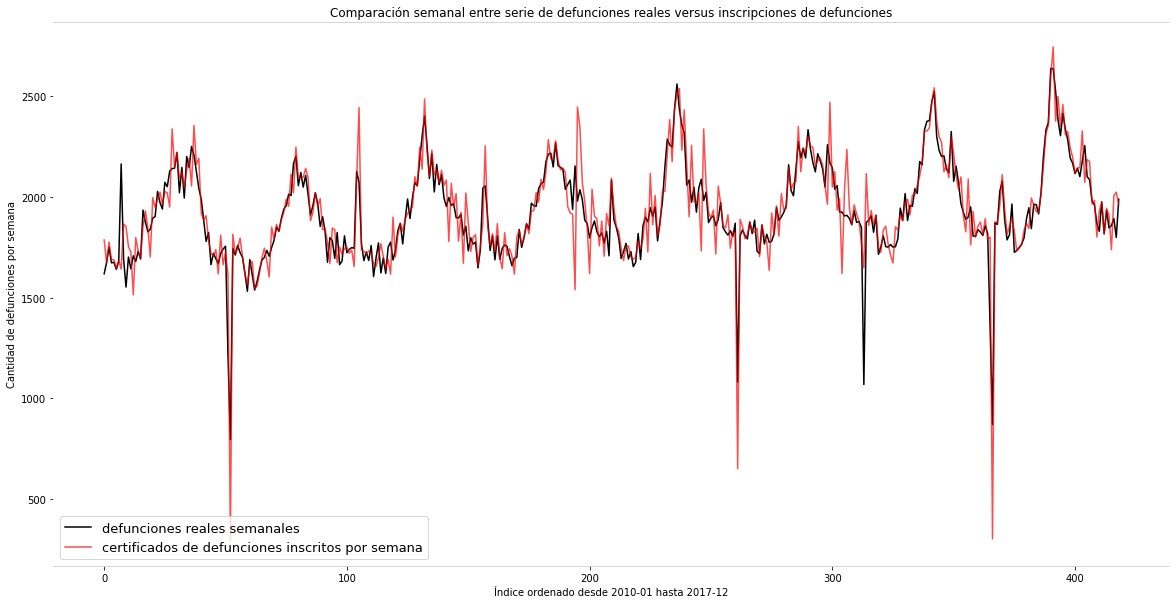

In [325]:
#--------------------------------------------
# GRÁFICO 2
#--------------------------------------------

#Librerías necesarias
import matplotlib.pyplot as plt
import numpy as np

#inciamos el gráfico y sus ejes
fig, ax = plt.subplots()
ax.plot(toplot2.index, 'REAL', data=toplot2, color='black')
ax.plot(toplot2.index, 'PROXY', data=toplot2, color='red', alpha = 0.7)

# formateamos la grilla
ax.grid(False)

# seteamos leyendas y título
ax.set_xlabel('Índice ordenado desde 2010-01 hasta 2017-12')
ax.set_ylabel('Cantidad de defunciones por semana')
ax.set_title('Comparación semanal entre serie de defunciones reales versus inscripciones de defunciones')

#tamaño del grafico
fig.set_figheight(10)
fig.set_figwidth(20)

# color de los ejes 
ax.spines['bottom'].set_color('#cccccc')
ax.spines['top'].set_color('#cccccc') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(('defunciones reales semanales', 'certificados de defunciones inscritos por semana')
          , loc='lower left', shadow=False, fontsize = 13)

plt.show

Esta vez vemos que en general tenemos comportamientos mucho más parecidos entre ambas series, por lo que haremos una prueba t para ver si podemos usar la proxy

In [330]:
# Hacemos una copia de toplot
error = toplot.copy()

# importamos la librería stats
from scipy.stats import ttest_ind

# generamos las series
s1 = error[['REAL']]
s2 = error[['PROXY']]

# aplicamos el test
ttest_ind(s1, s2)

Ttest_indResult(statistic=array([-0.6472622]), pvalue=array([0.51763995]))

Obtenemos un alto p-value, por lo que no se puede descartar que sus medias sean iguales. Calcularemos el promedio del error porcentual absoluto para tener una idea del error que podríamos estar cometiendo con la estimación.

In [331]:
#importamos la librería
import math

#Calculamos el error porcentual
error['diff'] = abs(error['REAL'] - error['PROXY']) /  error['PROXY'] * 100
print(error['diff'].agg(['mean', 'median', 'std']).astype(float))
print("90th percentil: " + str(error['diff'].quantile(.9)))


mean       4.631630
median     2.296211
std       13.372957
Name: diff, dtype: float64
90th percentil: 8.392508948726423


Ok, la verdad los resultados no son muy alentadores, ya que en promedio las series se diferncian un 5% una de otra, y pese a que un 50% de los datos no tengan un error mayor a 2,3%, para alcanzar un 90% vemos que eso sube a 8,4% que es un error considerable por día.
De todas maneras realizaremos el ejercicio, pero con las precauciones que:

- ### En términos gloables las diferencias son muy menores (0,56%)
- ### En términos semanales las diferencias son considerables, pues un 90% de los datos difieren en un 8,4% o menos y en promedio difieren 2,3%

In [332]:
#----------------------------------------------------------
## CARGAMOS 2020 para hacer el ejercicio de aproximación
#----------------------------------------------------------

df2020 = pd.read_excel('certificados/2020.xlsx', encoding = 'cp-1252')
# Agregamos por año, mes y día la columna total, ya que en el archivo los datos vienen desagregados por comuna.
df2020 = df2020.groupby(by = ['AÑO', 'MES', 'DIA'])['TOTAL'].sum().reset_index()

# Al igual que con los datos históricos hacemos un id fecha para poder luego hacer el cruce
df2020['Fecha'] = df2020['AÑO'].astype(str) + '-' + df2020['MES'].astype(int).astype(str) + '-' +df2020['DIA'].astype(int).astype(str)
df2020['Fecha'] = pd.to_datetime(df2020['Fecha'])

# renombramos la columna de totalización
df2020 = df2020.rename(columns = {'TOTAL': 'DEF2020'})
# añadimos el dato de población 
df2020['poblacion'] = 18549095

# Calculamos las defunciones por cada 100.000 habitantes 
df2020['DEF2020_10000'] = df2020['DEF2020'] / df2020['poblacion'] * 100000

# añadimos la semana
df2020['week'] =  df2020['Fecha'].dt.week

#Finalmente agregamos por promedio de defuncion por 100.000 
df2020C = df2020.groupby(['week'], as_index = False)['DEF2020_10000'].sum()


## Serie de datos de defunciones por COVID-19
La serie de datos de defunciones por COVID-19 se extrae desde el repositorio del [Ministerio de Ciencia](https://github.com/MinCiencia/Datos-COVID19/tree/master/output) para COVID, específicamente el [producto 5](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto5).
Se agradece que hayan automatizado esta serie, pues en las primeras versiones de este análisis, lo tuve que hacer extrayendo desde el informe en PDF, usando tabula-py, y se rompía cada vez que cambiaban la tabla 1.

A continuación podemos ver una muestra de esta serie:

In [334]:
pd.options.mode.chained_assignment = None  # default='warn'
temp1 = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto5/TotalesNacionales_T.csv")

temp1 = temp1[['Fecha', 'Fallecidos']]

temp2 = pd.DataFrame()
#Ciclo para llenar los dias sin datos
for i in range(0, 62):
    temp2 = temp2.append({'Fecha': datetime.date(2020, 1, 1) + datetime.timedelta(days=i), 'Fallecidos': 0}, ignore_index=True)
    
tempf = temp2.append(temp1, ignore_index = True)

temporal = tempf.copy()
for index, row in temporal.iterrows():
    if(tempf['Fallecidos'][index] == 0):
        temporal['Fallecidos'][index] = None

    
    else:
        temporal['Fallecidos'][index] = tempf['Fallecidos'][index] - tempf['Fallecidos'][index - 1]

temporal = temporal.rename(columns = {'Fallecidos': 'MuertesCOVID'})
temporal['MuertesCOVID'] = temporal['MuertesCOVID'].fillna(0).astype(int)
mCOVID = temporal.copy()
mCOVID.head()

,MuertesCOVID,Fecha
0,0,2020-01-01
1,0,2020-01-02
2,0,2020-01-03
3,0,2020-01-04
4,0,2020-01-05


In [335]:
#--------------------------------
# Trabajo con dataset descargado
#--------------------------------

# Ahora que tenemos las muertes vamos a generar los datos para que sean graficables

#Creamos el dataframe con solo los datos necesarios para el plot
dfx = pd.DataFrame(columns = ['Fecha', 'binario'])

#Ciclo para llenar los dias sin datos
for i in range(0, 62):
    dfx = dfx.append({'Fecha': datetime.date(2020, 1, 1) + datetime.timedelta(days=i), 'binario': 0}, ignore_index=True)

for i in range(62, len(mCOVID)):
    dfx = dfx.append({'Fecha': datetime.date(2020, 1, 1) + datetime.timedelta(days=i), 'binario': 1}, ignore_index=True)

# Pasamos los datos de fecha a formato pandas
dfx['Fecha'] = pd.to_datetime(dfx['Fecha'])
mCOVID['Fecha'] = pd.to_datetime(mCOVID['Fecha'])

# Unimos los datasets y agregamos el dato de población 2020 proyectada
temp = dfx.merge(mCOVID, how = 'left', left_on = 'Fecha', right_on = 'Fecha')
temp['poblacion'] = 18549095

In [336]:
# hacemos los mismo para datos de fecha de df2020
temp['Fecha'] = pd.to_datetime(temp['Fecha'])

# Calculamos las defunciones por cada 100.000 habitantes 
temp['DEFCOVID_10000'] = temp['MuertesCOVID'] / temp['poblacion'] * 100000

# añadimos la semana
temp['week'] =  temp['Fecha'].dt.week
temp['week'] = temp['week'].fillna(max(temp['week'])) #TEMPORAL MIENTRAS ARREGLAN LA FUENTE DE DATOS

#Finalmente agregamos por promedio de defuncion por 100.000 
temp = temp.groupby(['week'], as_index = False)['DEFCOVID_10000'].sum()

In [337]:
#calculamos el la serie a graficar 
fCovid = temp.copy()

#unimos con la serie histórica
fCovid = fCovid.merge(fPromFallecidos, how= 'left', left_on = 'week', right_on = 'week')

#Calculamos las series a graficar
fCovid['DEFCOVID_10000'] = fCovid['mean'] + fCovid['DEFCOVID_10000']
fCovid['hiCov'] = (fCovid['hi'] - fCovid['mean'] + fCovid['DEFCOVID_10000'])
fCovid['lowCov'] = (fCovid['DEFCOVID_10000'] - (fCovid['mean'] - fCovid['low']))

In [338]:
# Unimos todo en un gran dataset antes de graficar

fCovidF = fCovid.merge(df2020C, how = 'left', left_on = 'week', right_on = 'week')
fCovidF = fCovidF[['week', 'DEFCOVID_10000', 'mean', 'DEF2020_10000', 'hi',	'low', 'hiCov', 'lowCov']]

#reindexamos
fCovidF.index = np.arange(1, len(fCovidF) + 1)

In [339]:
# eliminamos manual la última semana porque no está completa
fCovidF = fCovidF[:19][:]
fCovidF['week'] =  fCovidF['week'].astype(int)

## Gráfico
A continuación se presenta el gráfico con las tres series ya expuestas, presentadas en términos de defunciones diarias por cada 100.000 habitantes.

***Gráfico 3: Evolución de defunciones promedio por cada 100.000 vs COVID-19 versus 2020 (ESTIMACION EN BASE A CERTIFICADO)***

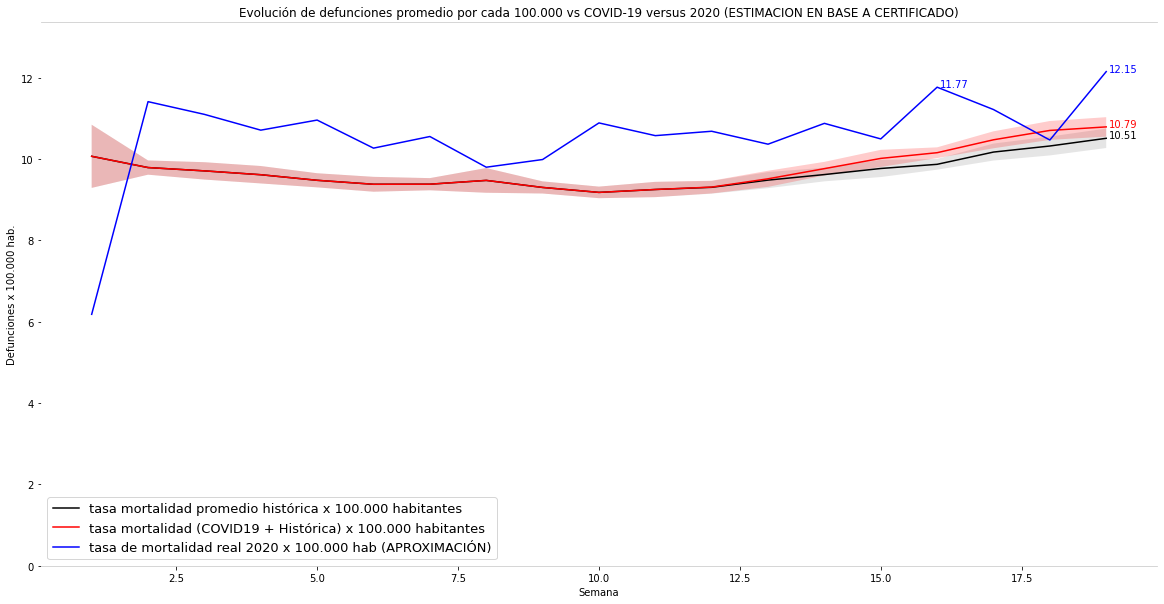

In [343]:
#--------------------------------------------
# GRÁFICO 3
#--------------------------------------------

#Librerías necesarias
import matplotlib.pyplot as plt
import numpy as np

#inciamos el gráfico y sus ejes
fig, ax = plt.subplots()
ax.plot('week', 'mean', data=fCovidF, color='black')
ax.plot('week', 'DEFCOVID_10000', data=fCovidF, color='red')
ax.plot('week', 'DEF2020_10000', data=fCovidF, color='blue')


ax.fill_between(fCovidF.index, fCovidF.low, fCovidF.hi, facecolor='grey', alpha=.2)
ax.fill_between(fCovidF.index, fCovidF.lowCov, fCovidF.hiCov, facecolor='red', alpha=.2)

# delimitamos el eje y
ax.set_ylim([0, np.nanmax(fCovidF['DEF2020_10000'].values) + np.nanmax(fCovidF['DEF2020_10000'].values) * 0.1 ])


# formateamos la grilla
ax.grid(False)

# seteamos leyendas y título
ax.set_xlabel('Semana')
ax.set_ylabel('Defunciones x 100.000 hab.')
ax.set_title('Evolución de defunciones promedio por cada 100.000 vs COVID-19 versus 2020 (ESTIMACION EN BASE A CERTIFICADO)')

#tamaño del grafico
fig.set_figheight(10)
fig.set_figwidth(20)

# color de los ejes 
ax.spines['bottom'].set_color('#cccccc')
ax.spines['top'].set_color('#cccccc') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(('tasa mortalidad promedio histórica x 100.000 habitantes', 'tasa mortalidad (COVID19 + Histórica) x 100.000 habitantes',\
          'tasa de mortalidad real 2020 x 100.000 hab (APROXIMACIÓN)')
          , loc='lower left', shadow=False, fontsize = 13)

plt.text(fCovidF['week'][len(fCovidF)] + 0.05, fCovidF['DEF2020_10000'][len(fCovidF)], round(fCovidF['DEF2020_10000'][len(fCovidF)], 2), color = 'blue')
plt.text(fCovidF['week'][16] + 0.05, fCovidF['DEF2020_10000'][16], round(fCovidF['DEF2020_10000'][16], 2), color = 'blue')
plt.text(fCovidF['week'][len(fCovidF)] + 0.05, fCovidF['DEFCOVID_10000'][len(fCovidF)], round(fCovidF['DEFCOVID_10000'][len(fCovidF)], 2), color = 'red')
plt.text(fCovidF['week'][len(fCovidF)] + 0.05, fCovidF['mean'][len(fCovidF)], round(fCovidF['mean'][len(fCovidF)], 2), color = 'black')

plt.show()

### ¿Cómo interpretar el gráfico?
La serie de color negro corresponde a las defunciones promedio diaria desde 1990 a 2017 por cada 10.000 habitantes en Chile
La serie roja es una serie compuesta que a partir del primer reporte de COVID-19 emitido oficialmente por el MINSAL comienza a tener data. La combinación es la suma de la serie negra con la serie de defunciones por COVID-19 por cada 10.000 habitantes diarias. Es decir, muestra cuanto ha afectado el COVID-19 a la tasa de mortalidad promedio, asumiendo que la tasa de mortalidad de aquellos quienes fallecieron por razones distintas al COVID-19 sigue la tendencia promedio. 

Además en gris se pueden ver los límites del intervalo de confianza de 95% para la serie histórica. En rojo claro, el intervalo de confianza para la serie combinada de histórico + COVID-19

#### Como se puede apreciar se presentan diferencias significativas entre la serie real 2020 versus la combinada, el problema es que, el error que tenemos de 8,3% no explicaría esta diferencia, sin embargo, como vemos este año han habido inscripciones de defunciones semanales en una mayor cantidad que las defunciones reales semanales promedio, sin embargo estas no van al alza, sino que han sido superiores durante gran parte de las semanas del año, y esto podría estar explicado porque la serie histórica solo llega hasta 2017. Para evitar la distorsión de comparar un proxy con un dato real hice uso de la serie histórica de certificados y es lo que presenta a continuación

### Análisis usando como base histórica los datos de Certificados

In [340]:
#hacemos una copia de la serie que ocuparemos y aplicamos las trasnfromaciones necesarias
histCert = toplot.copy()
histCert = histCert.merge(proyPobla, how = 'left', left_on = 'AÑO', right_on = 'ANIO')
histCert['PROXY_10000'] = round(histCert['PROXY'] / histCert['POBLACION'] * 100000, 2)
hCA = histCert.groupby(['week'])['PROXY_10000'].agg(['mean', 'count', 'std']).reset_index()

hCA['hi'] = hCA['mean'] + (1.96 * hCA['std'] / np.sqrt(hCA['count']))
hCA['low'] = hCA['mean'] - (1.96 * hCA['std'] / np.sqrt(hCA['count']))

dfcovidint = temp.copy()
dfcovidint['week'] = dfcovidint['week'].astype(int)
dfcp = hCA.merge(dfcovidint, how = 'left', left_on = 'week', right_on = 'week')

dfcp['DEFCOVID_10000'] = dfcp['mean'] + dfcp['DEFCOVID_10000']
dfcp['hiCov'] = (dfcp['hi'] - dfcp['mean'] + dfcp['DEFCOVID_10000'])
dfcp['lowCov'] = (dfcp['DEFCOVID_10000'] - (dfcp['mean'] - dfcp['low']))

dfcpf = df2020C.merge(dfcp, how = 'left', left_on = 'week', right_on = 'week')
dfcpf.index = np.arange(1, len(dfcpf) + 1)
dfcpf = dfcpf[:19][:]


***Gráfico 4: Evolución de inscripciones de defunciones promedio (2010 -2019) por cada 100.000 vs COVID-19 versus 2020 (Datos de certificado de defunción)***

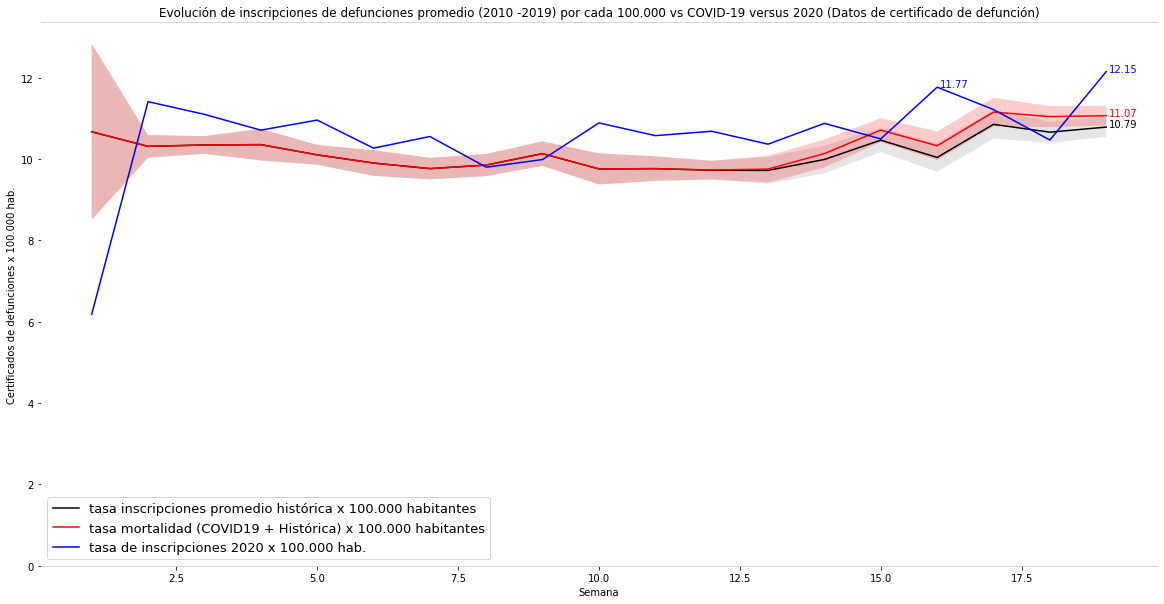

In [342]:
#--------------------------------------------
# GRÁFICO 4
#--------------------------------------------
# finalmente graficamos con pyplot, sientase libre cualquiera de usar algo más fancy

#Librerías necesarias
import matplotlib.pyplot as plt
import numpy as np

#inciamos el gráfico y sus ejes
fig, ax = plt.subplots()
ax.plot('week', 'mean', data=dfcpf, color='black')
ax.plot('week', 'DEFCOVID_10000', data=dfcpf, color='red')
ax.plot('week', 'DEF2020_10000', data=dfcpf, color='blue')


ax.fill_between(dfcpf.index, dfcpf.low, dfcpf.hi, facecolor='grey', alpha=.2)
ax.fill_between(dfcpf.index, dfcpf.lowCov, dfcpf.hiCov, facecolor='red', alpha=.2)

# delimitamos el eje y
ax.set_ylim([0, np.nanmax(dfcpf['DEF2020_10000'].values) + np.nanmax(dfcpf['DEF2020_10000'].values) * 0.1 ])


# formateamos la grilla
ax.grid(False)

# seteamos leyendas y título
ax.set_xlabel('Semana')
ax.set_ylabel('Certificados de defunciones x 100.000 hab.')
ax.set_title('Evolución de inscripciones de defunciones promedio (2010 -2019) por cada 100.000 vs COVID-19 versus 2020 (Datos de certificado de defunción)')

#tamaño del grafico
fig.set_figheight(10)
fig.set_figwidth(20)

# color de los ejes 
ax.spines['bottom'].set_color('#cccccc')
ax.spines['top'].set_color('#cccccc') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(('tasa inscripciones promedio histórica x 100.000 habitantes', 'tasa mortalidad (COVID19 + Histórica) x 100.000 habitantes',\
          'tasa de inscripciones 2020 x 100.000 hab.')
          , loc='lower left', shadow=False, fontsize = 13)

plt.text(dfcpf['week'][len(dfcpf)] + 0.05, dfcpf['DEF2020_10000'][len(dfcpf)], round(dfcpf['DEF2020_10000'][len(dfcpf)], 2), color = 'blue')
plt.text(dfcpf['week'][16] + 0.05, dfcpf['DEF2020_10000'][16], round(dfcpf['DEF2020_10000'][16], 2), color = 'blue')
plt.text(dfcpf['week'][len(dfcpf)] + 0.05, dfcpf['DEFCOVID_10000'][len(dfcpf)], round(dfcpf['DEFCOVID_10000'][len(dfcpf)], 2), color = 'red')
plt.text(dfcpf['week'][len(dfcpf)] + 0.05, dfcpf['mean'][len(dfcpf)], round(dfcpf['mean'][len(dfcpf)], 2), color = 'black')

plt.show()

Como vemos en el gráfico 4, las series se acercaron, si lo comparamos con el gráfico 3, sin embargo 2020 sigue estando por sobre la serie histórica en varias semanas y aunque no pareciera tener una tendencia al alza, es muy prematuro aseverarlo con certeza.

## ¿Por qué es importante este gráfico?

El efecto de la pandemia sobre la tasa de mortalidad nos puede dar luces del impacto de esta enfermedad sobre el sistema de salud, y con ello tomar medidas más estrictas en base a este indicador.
La verdad me sorporendí con los pocos datos que existen sobre mortalidad en el mundo, es difícil encontrar datos, en otros paises sudamericanos, incluso USA, pero en Europa, por suerte, es distinto.
Encontré las cifras de defunciones generales semanales desde 2010 a marzo 2020 de Inglaterra y Gáles, así como sus cifras de defunciones debido a COVID.
Con los datos descritos, ya es posible replicar el análisis, y quiero mostrarles la razón de que sea importante revisar este indicador

https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales

In [344]:
import ssl

In [345]:
import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2010/publishedweek2010.xls', "2010.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2011/publishedweek2011.xls', "2011.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2012/publishedweek2012.xls', "2012.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2013/publishedweek2013.xls', "2013.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2014/publishedweek2014.xls', "2014.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2015/publishedweek2015.xls', "2015.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2016/publishedweek522016.xls', "2016.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2017/publishedweek522017.xls', "2017.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2018/publishedweek522018withupdatedrespiratoryrow.xls', "2018.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2019/publishedweek522019.xls', "2019.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2020/publishedweek182020.xlsx', "2020.xls")


('2020.xls', <http.client.HTTPMessage at 0x2412547c9c8>)

In [346]:
#fuentes de población
#2010 - 2018 England
#https://www.ons.gov.uk/generator?format=xls&uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/timeseries/enpop/pop

#2010 - 2018 Wales
#https://www.ons.gov.uk/generator?format=xls&uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/timeseries/wapop/pop

#proyeccion
#https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationprojections%2fdatasets%2ftablea23principalprojectionenglandandwalespopulationinagegroups%2f2018based/ewpppsumpop18.xls

In [347]:
## dfhist
import pandas as pd
import numpy as np
dfConsol = pd.DataFrame()

for i in range(0,10):
    y = 2010 + i
    xls = pd.ExcelFile(str(y) + '.xls')
    if (y < 2016):
        df = pd.read_excel(xls,'Weekly Figures ' + str(y))
    else:
        df = pd.read_excel(xls,'Weekly figures ' + str(y))
    
    df = df[(df['Contents'] == 'Total deaths, all ages')|(df['Contents'] == 'Week number')]
    df = df.reset_index().T
    df.columns = df.iloc[1]
    df = df[2:]
    df['year'] = y
    dfConsol = dfConsol.append(df)

dfConsol = dfConsol.reset_index()
dfConsol = dfConsol.drop(columns = {'index'})

dfConsol['Total deaths, all ages'] = pd.to_numeric(dfConsol['Total deaths, all ages'], errors='coerce')

pop = pd.DataFrame({'year': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],\
                   'pop': [55692500, 56171000, 56567800, 56948200, 57408600, 57885400, 58381300, 58744600, 59115809, 59488102, 59829234]})


dfConsol = dfConsol.merge(pop, how = 'left', left_on='year', right_on='year')
dfConsol['DRx10000'] = dfConsol['Total deaths, all ages'] / dfConsol['pop'] * 10000

dTemp = dfConsol.drop(columns = {'year', 'Total deaths, all ages', 'pop'})
dfWeekHist = dTemp.groupby(['Week number'], as_index = False)['DRx10000'].agg(['mean', 'count', 'std']).reset_index()
dfWeekHist['low'] = dfWeekHist['mean']  - (1.96 * dfWeekHist['std'] / np.sqrt(dfWeekHist['count']))
dfWeekHist['hi'] = dfWeekHist['mean']  + (1.96 * dfWeekHist['std'] / np.sqrt(dfWeekHist['count']))
dfWeekHist = dfWeekHist.drop(columns = {'std', 'count'})

In [348]:
# df2020
xls = pd.ExcelFile('2020.xls')
df2020 = pd.read_excel(xls,'Weekly figures 2020')

df2020 = df2020[(df2020['Contents'] == 'Total deaths, all ages')|(df2020['Contents'] == 'Week number')]
df2020 = df2020.reset_index().T
df2020.columns = df2020.iloc[1]
df2020 = df2020[2:]
df2020['year'] = 2020
df2020 = df2020.dropna()

df2020 = df2020.reset_index()
df2020 = df2020.drop(columns = {'index'})

df2020['Total deaths, all ages'] = pd.to_numeric(df2020['Total deaths, all ages'], errors='coerce')
df2020['pop'] = 59829234
df2020['DR2020x10000'] = df2020['Total deaths, all ages'] / df2020['pop'] * 10000

df2020 = df2020.drop(columns={'Total deaths, all ages', 'year', 'pop'})

In [349]:
#dfCOVID
xls = pd.ExcelFile('2020.xls')
dfCovid = pd.read_excel(xls,'Covid-19 - Weekly registrations')
dfCovid = dfCovid[(dfCovid['Contents'] == 'Deaths involving COVID-19, all ages1')|(dfCovid['Contents'] == 'Week number')]
dfCovid = dfCovid.reset_index().T
dfCovid.columns = dfCovid.iloc[1]
dfCovid = dfCovid[2:]
dfCovid['year'] = 2020
dfCovid = dfCovid.dropna()

dfCovid = dfCovid.reset_index()
dfCovid = dfCovid.drop(columns = {'index'})

dfCovid['Deaths involving COVID-19, all ages1'] = pd.to_numeric(dfCovid['Deaths involving COVID-19, all ages1'], errors='coerce')
dfCovid['pop'] = 59829234
dfCovid['DRCOVIDx10000'] = dfCovid['Deaths involving COVID-19, all ages1'] / dfCovid['pop'] * 10000

dfCovid = dfCovid.drop(columns={'Deaths involving COVID-19, all ages1', 'year', 'pop'})

In [350]:
# Consolidacion
import math

dfEngland = dfCovid.merge(dfWeekHist, how = 'left', left_on = 'Week number', right_on = 'Week number')
dfEngland = dfEngland.merge(df2020, how = 'left', left_on = 'Week number', right_on = 'Week number')
dfEngland['CompCovid'] = dfEngland['DRCOVIDx10000'] + dfEngland['mean']
dfEngland.loc[dfEngland['DRCOVIDx10000'] == 0, 'CompCovid'] = math.nan
dfEngland = dfEngland.drop(columns = {'DRCOVIDx10000'})



dfEngland.index = np.arange(1, len(dfEngland) + 1)

In [351]:
dfEngland['lowCov'] = math.nan
dfEngland.loc[dfEngland['Week number'] > 10, 'lowCov'] = dfEngland['CompCovid'] - (dfEngland['mean'] - dfEngland['low'])

dfEngland['hiCov'] = math.nan
dfEngland.loc[dfEngland['Week number'] > 10, 'hiCov'] = dfEngland['CompCovid'] + (dfEngland['mean'] - dfEngland['low'])

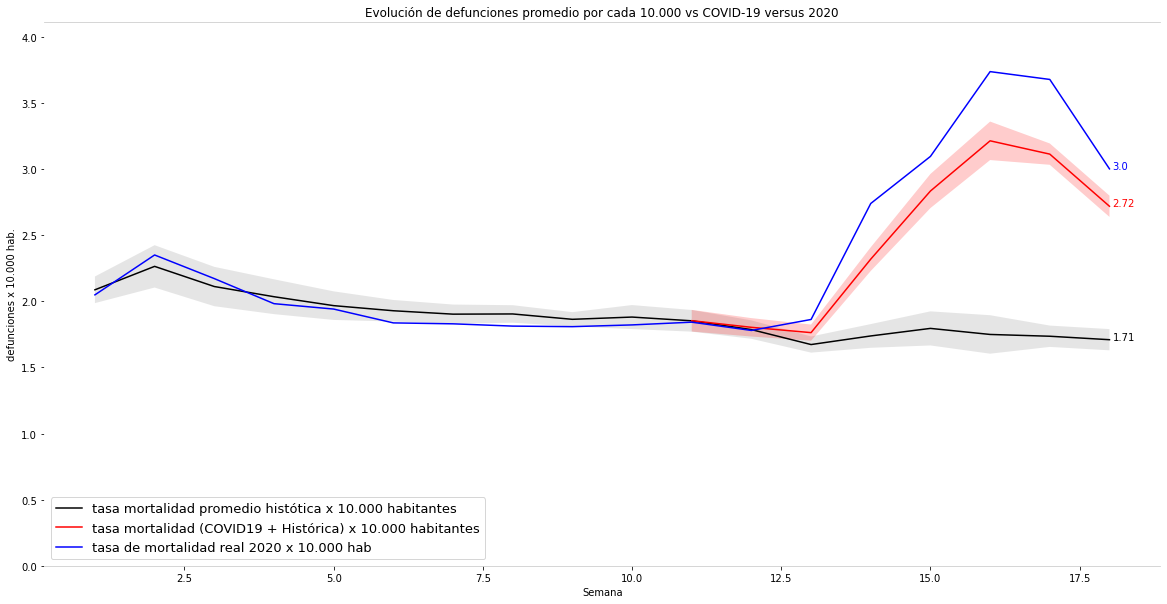

In [352]:
#--------------------------------------------
# GRÁFICO
#--------------------------------------------
# finalmente graficamos con pyplot, sientase libre cualquiera de usar algo más fancy

#Librerías necesarias
import matplotlib.pyplot as plt
import numpy as np

#inciamos el gráfico y sus ejes
fig, ax = plt.subplots()
ax.plot('Week number', 'mean', data=dfEngland, color='black')
ax.plot('Week number', 'CompCovid', data=dfEngland, color='red')
ax.plot('Week number', 'DR2020x10000', data=dfEngland, color='blue')


ax.fill_between(dfEngland.index, dfEngland.low, dfEngland.hi, facecolor='grey', alpha=.2)
ax.fill_between(dfEngland.index, dfEngland.lowCov, dfEngland.hiCov, facecolor='red', alpha=.2)

# delimitamos el eje y
ax.set_ylim([0, np.nanmax(dfEngland['DR2020x10000'].values) + np.nanmax(dfEngland['DR2020x10000'].values) * 0.1 ])


# formateamos la grilla
ax.grid(False)

# seteamos leyendas y título
ax.set_xlabel('Semana')
ax.set_ylabel('defunciones x 10.000 hab.')
ax.set_title('Evolución de defunciones promedio por cada 10.000 vs COVID-19 versus 2020')

#tamaño del grafico
fig.set_figheight(10)
fig.set_figwidth(20)

# color de los ejes 
ax.spines['bottom'].set_color('#cccccc')
ax.spines['top'].set_color('#cccccc') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(('tasa mortalidad promedio histótica x 10.000 habitantes', 'tasa mortalidad (COVID19 + Histórica) x 10.000 habitantes',\
          'tasa de mortalidad real 2020 x 10.000 hab')
          , loc='lower left', shadow=False, fontsize = 13)

plt.text(dfEngland['Week number'][len(dfEngland['Week number'])] + 0.05, dfEngland['DR2020x10000'][len(dfEngland['DR2020x10000'])], round(dfEngland['DR2020x10000'][len(dfEngland['DR2020x10000'])], 2), color = 'blue')
plt.text(dfEngland['Week number'][len(dfEngland['Week number'])] + 0.05, dfEngland['CompCovid'][len(dfEngland['CompCovid'])], round(dfEngland['CompCovid'][len(dfEngland['CompCovid'])], 2), color = 'red')
plt.text(dfEngland['Week number'][len(dfEngland['Week number'])] + 0.05, dfEngland['mean'][len(dfEngland['mean'])], round(dfEngland['mean'][len(dfEngland['mean'])], 2), color = 'black')

plt.show()

In [353]:
import os
cwd = os.getcwd()
for i in range(0,11):
    a = 2010 + i
    os.remove(cwd + '\\' + str(a) + '.xls')

Como se aprecia en el gráfico la diferencia entre la suma de las series COVID + Histórica (linea roja) y defunciones reales 2020, es significativa.
Frente a esto nos surge las dudas:
- ¿A qué se debe esta diferencia?
- ¿Se están contabilizando correctamente las defunciones por COVID?
- ¿El factor COVID ha incidido en la muerte por otras causas?

Y la pregunta principal:
- **¿Está pasando esto en Chile?**

    ###    Aparentemente no, pero esto sigue siendo un aproximación a los datos reales, que esperemos sean liberados.